In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress

In [2]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

def msd_from_gsd(gsdfile, start=-10, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

In [3]:
project = signac.get_project("ptb7-project")
state_dict = {"size": "small",
             "density": 0.8,
             "molecule": "PTB7_5mer_smiles"}
state_dict['density.$lt'] = 1.3

slope is:
3.68277e+01


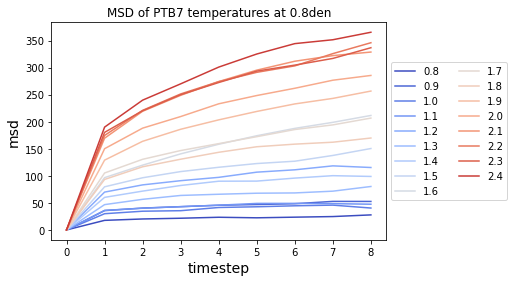

In [6]:
job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    x = 30
    msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='ss')
    plt.plot(msd, label=job.sp['kT_reduced'])
plt.title("MSD of PTB7 temperatures at %sden" % (job.sp['density']))
plt.xlabel("timestep", fontsize=14)
plt.ylabel("msd", fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

y = msd[-15:]
x = range(len(y))

slope, intercept, r_value, p_value, std_err = linregress(x, y)
#plt.plot(x, x*slope + intercept, linestyle = 'dotted')
print("slope is:")
print("%10.5e"% slope)

#job.doc.msd_slope = slope

plt.show()